In [ ]:
# example-landau-fit-for-bool-ode-data.ipynb
#
# Bryan Daniels
# 2023/10/25
#
# Example of running the "Landau" data analysis code (found 
# here: https://github.com/Collective-Logic-Lab/landau )
# on data produced by BoolODE.
#
# Much of this code was forked from what I wrote for the
# Spring 2023 grant proposal, found in 
# Control-of-Synthetic-Boolean-Networks/code/BoolODE_data.ipynb
#

# load BoolODE data

In [46]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm # for progress bars

In [11]:
# read expression data into pandas DataFrame
dataDir = '../Bool ODE outputs/pRogress_4/'
expression = pd.read_csv('{}/ExpressionData.csv'.format(dataDir),
                         index_col=0).T

In [10]:
# look at the DataFrame to see what we're working with
# (here 1000 cells with 5 gene expressions each)
expression

,g1,g2,g3,g4,g5
E0_237,2.364032,1.818055,0.000512,0.035562,0.003712
E1_233,1.916502,1.499494,0.000728,0.003854,0.072445
E2_186,1.467022,2.211753,0.038807,0.018330,0.016627
E3_438,2.222070,2.299621,0.012180,0.015372,0.001413
E4_268,1.980141,1.762307,0.014171,0.021510,0.007766
...,...,...,...,...,...
E995_60,1.688257,0.018741,0.015908,0.109149,0.039773
E996_206,2.288173,1.770626,0.002179,0.057767,0.015837
E997_234,2.071044,1.774852,0.001091,0.003413,0.012631
E998_11,0.561608,0.001382,0.519313,0.848467,0.466121


In the BoolODE data, we know the timepoint at which each cell was sampled.  (In real data, we won't know this, but we'll deal with this fact later using RNA velocity.)  In BoolODE, the relevant time is known as the "pseudotime" (I think).  We load these times here from the file "PseudoTime.csv":

In [19]:
times_raw = pd.read_csv('{}/PseudoTime.csv'.format(dataDir),
                       index_col=0)
# keep just the 'PseudoTime' column and just the rows corresponding 
# to the sampled cells (those in expression.index)
times = times_raw['PseudoTime'].loc[expression.index]

In [20]:
times

E0_237      0.473896
E1_233      0.465863
E2_186      0.371486
E3_438      0.877510
E4_268      0.536145
              ...   
E995_60     0.118474
E996_206    0.411647
E997_234    0.467871
E998_11     0.020080
E999_499    1.000000
Name: PseudoTime, Length: 1000, dtype: float64

# do landau analysis to highlight potential control nodes

In [1]:
from landau import landauAnalysis

For the analysis, we want to split the cells into sub-populations that all have similar pseudotime.  So we will pick time windows that include enough cells — let's try for roughly 50 cells per time window.  For now, we'll just split pseudotime (which ranges from 0 to 1) into `Nwindows` equal windows.

*(Eventually we might change this to include a constant number of cells in each window?)*

In [64]:
# set up a series of time windows

Nwindows = 10 #20
landauDataList = []
cells_to_use_list = []
t_min_list = np.linspace(0,1,Nwindows)
delta_t = t_min_list[1] - t_min_list[0]

for t_min in t_min_list:
    # restrict to varying time window
    t_max = t_min+delta_t
    cells_to_use = (times >= t_min) & (times < t_max)
    cells_to_use_list.append(cells_to_use)

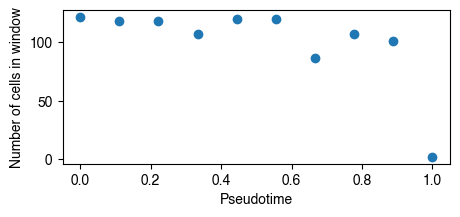

In [65]:
plt.figure(figsize=(5,2))
plt.plot(t_min_list,[ len(expression[cells]) for cells in cells_to_use_list ],'o')
plt.xlabel('Pseudotime')
plt.ylabel('Number of cells in window');

Next the `landauAnalysis` function finds the principal component of each population of cells and determines whether it shows evidence of bistability (that is, whether the population has split into two groups).

In [66]:
#landauDataList = []
for cells_to_use in tqdm(cells_to_use_list):
    landauData = landauAnalysis.landauAnalysis(expression[cells_to_use])
    landauDataList.append(landauData)

100%|███████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


The relevant statistic for determining whether there is bistability is the BIC (Bayesian Information Criterion), which is stored in the output of `landauAnalysis` in `bicDiffList`.  (Note: `bicDiffList` is stored as a list of length 1 for complicated historical reasons...)  There is strong evidence of bistability if the BIC is less than -6.  We can plot the BIC as a function of time to see when it becomes less than -6:

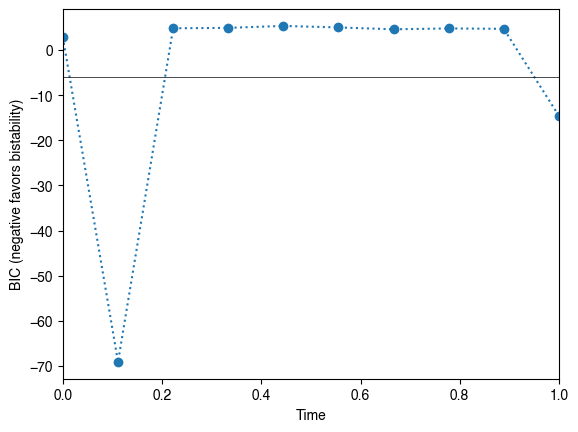

In [69]:
plt.plot(t_min_list,[data['bicDiffList'][0] for data in landauDataList],'o:')
tmin,tmax = 0,1
plt.hlines(-6,tmin,tmax,color='k',lw=0.5) # plot horizontal line at -6
plt.axis(xmin=tmin,xmax=tmax)
plt.xlabel('Time')
plt.ylabel('BIC (negative favors bistability)');

We are still refining how to best select the correct time here to look for control genes.  Most naively, we might try the first time window in which BIC becomes less than -6.

In [102]:
first_bistable_time_index = [data['bicDiffList'][0] < -6 for data in landauDataList].index(True)
print("The first evidence for bistability happens at time = {:.3f}".format(t_min_list[first_bistable_time_index]))

The first evidence for bistability happens at time = 0.111


Our current hypothesis is that, at this time of first bistability, the genes with the largest proportion of their variance along the principal component (a number we call $s$) are the most likely control nodes.

In [83]:
def s(expression_data,Jnu):
    """
    Compute the proportion of variance for each gene along the principal component.
    
    Currently takes as input `Jnu` from landauAnalysis.  Could probably compute that here
    so we don't have to rely on landauAnalysis code.
    """
    vals,vecs = landauAnalysis.principalComponents(expression_data)
    pc = pd.Series(vecs[0], index=expression_data.columns)
    variances = pd.Series(np.diag(expression_data.cov(ddof=0)), index=expression_data.columns)
    return pc**2 / Jnu / variances

In [84]:
# compute s values for all time windows
sList = []
for transitionIndex in range(len(t_min_list)):
    expression_slice = expression[cells_to_use_list[transitionIndex]]
    Jnu = landauDataList[transitionIndex]['valList'][0]
    sList.append(s(expression_slice,Jnu))

The predicted control node(s) are the ones with largest $s$ at the relevant time window:

In [89]:
print('Genes sorted by s:')
sList[first_bistable_time_index].sort_values(ascending=False)

Genes sorted by s:


g1    0.915702
g5    0.841495
g4    0.831425
g3    0.805136
g2    0.099994
dtype: float64

# visualize the data

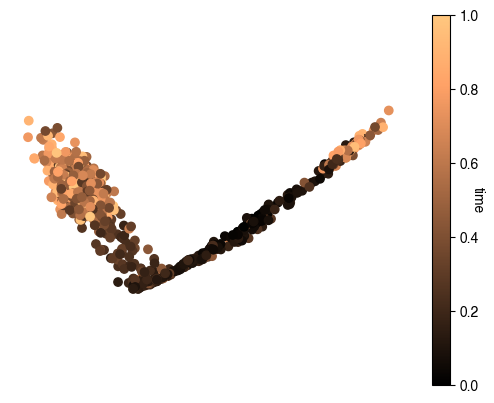

In [99]:
# PCA
vals,vecs = landauAnalysis.principalComponents(expression)
projected0 = np.dot(expression,vecs[0])
projected1 = np.dot(expression,vecs[1])

plt.scatter(projected0,projected1,c=times,cmap='copper')
cbar = plt.colorbar()
cbar.set_label('time',rotation=270)
plt.axis('equal')
plt.axis('off');

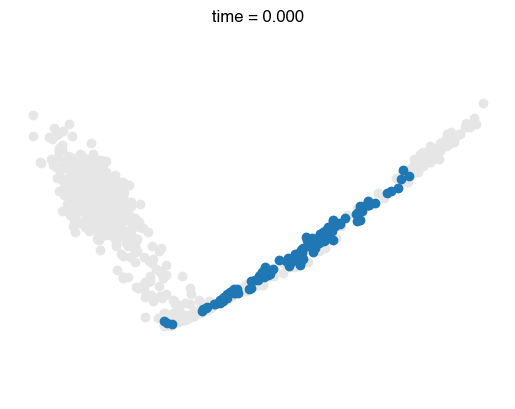

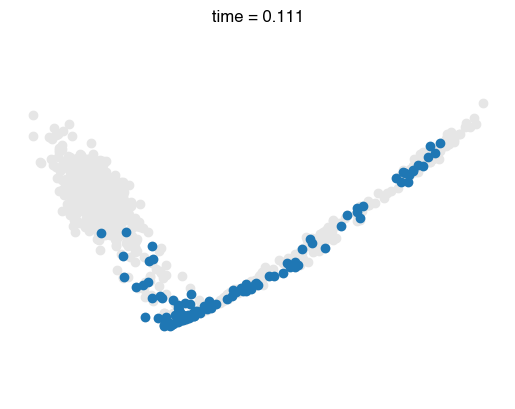

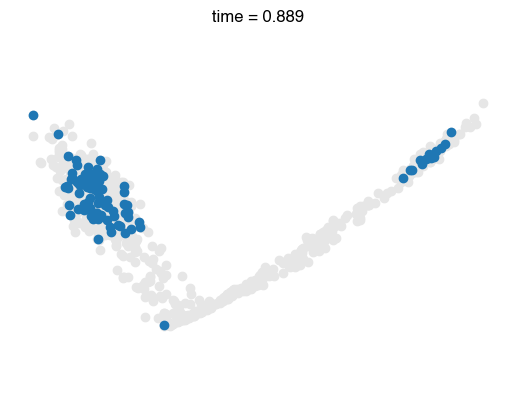

In [103]:
# plot cells from individual time windows on the original PCA axes
time_index_list = [0,1,8]
for time_index in time_index_list:
    plt.figure()
    plt.scatter(projected0,
                projected1,
                c='0.9')
    plt.scatter(projected0[cells_to_use_list[time_index]],
                projected1[cells_to_use_list[time_index]],
                c='C0')
    plt.axis('equal')
    plt.axis('off')
    plt.title("time = {:.3f}".format(t_min_list[time_index]))